## Overview

Time series models are used in a wide range of applications, particularly for forecasting.

This notebook contains lab material for familarizing with key aspects of time series analysis. Here, we will perform analyses on a time series of California dairy data. Specifically, we will explore the structure of the time series and forecast the monthly production of fresh milk in the state of California.

This exploration is performed in four steps:

* Explore the characteristics of the time series data.
* Decompose the time series of monthly milk production into trend, seasonal components, and remainder components.
* Apply time series models to the remainder component of the time series.
* Forecast the production of monthly milk production for a 12 month period.

## Load and Examine the Data

As a first step, read the data from the csv file and load it into a dataframe.

In [1]:
# import dependencies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# define the file path and read the csv file into a dataframe
file = "cadairydata.csv"
df = pd.read_csv(file,encoding="ISO-8859-1")
df.head()

,Unnamed: 0,Year.Month,Month.Number,Year,Month,Cotagecheese.Prod,Icecream.Prod,Milk.Prod,N.CA.Fat.Price
0,1,1995.01,1,1995,Jan,4.370,51.595,2.112,0.9803
1,2,1995.02,2,1995,Feb,3.695,56.086,1.932,0.8924
2,3,1995.03,3,1995,Mar,4.538,68.453,2.162,0.8924
3,4,1995.04,4,1995,Apr,4.280,65.722,2.130,0.8967
4,5,1995.05,5,1995,May,4.470,73.730,2.227,0.8967


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 228 entries, 0 to 227
Data columns (total 9 columns):
Unnamed: 0           228 non-null int64
Year.Month           228 non-null float64
Month.Number         228 non-null int64
Year                 228 non-null int64
Month                228 non-null object
Cotagecheese.Prod    228 non-null float64
Icecream.Prod        228 non-null float64
Milk.Prod            228 non-null float64
N.CA.Fat.Price       228 non-null float64
dtypes: float64(5), int64(3), object(1)
memory usage: 16.1+ KB


The next step is to do some data processing.

1. The Month column is ordered using str function so that all months are represented by first three characters of their name.
2. A new column, Date, is created. It is a datetime object.
3. Some uncessary columns are removed.

 Now, the data frame inlcudes Year, Month, and Date column with calendar information. The other column shows the production of milk.

In [4]:
df['Month'] = df['Month'].str[:3]

df = df.rename(columns={"Month.Number":"Month","Month":"Month.Name"})
df['Day'] = pd.Series(['01']*len(df))
df['Date'] =pd.to_datetime(df[["Year","Month","Day"]])

df = df.drop(["Unnamed: 0","Year.Month","Cotagecheese.Prod","Icecream.Prod","N.CA.Fat.Price","Day"],
             axis=1)

df.head()

,Month,Year,Month.Name,Milk.Prod,Date
0,1,1995,Jan,2.112,1995-01-01
1,2,1995,Feb,1.932,1995-02-01
2,3,1995,Mar,2.162,1995-03-01
3,4,1995,Apr,2.130,1995-04-01
4,5,1995,May,2.227,1995-05-01


## Create a Time Series Plot

Now that the data frame has been examined, we will create a time series plot of milk production.
The production of milk is shown on the vertical scale and the date is on the horizontal scale.

Text(0.5,1,'Milk Production in California')

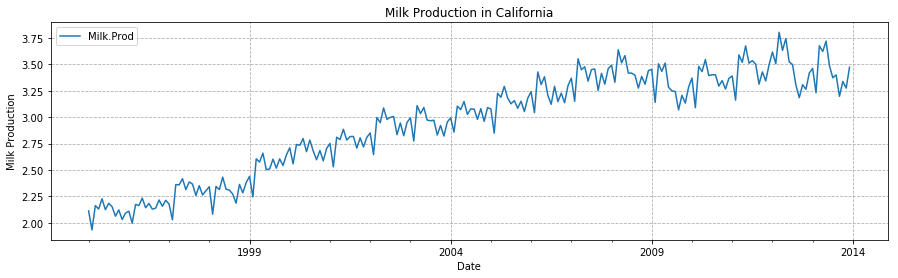

In [5]:
fig = plt.figure(figsize=(15,4))
ax = fig.gca()
df.plot(x="Date",y="Milk.Prod",ax=ax)
ax.grid(linestyle='--')
ax.set_xlabel("Date")
ax.set_ylabel("Milk Production")
ax.set_title("Milk Production in California")

For most of the time period shown, the production of milk increased year over year. However, there is a decline in milk production starting in 2009 as a results of the recession. Also, notice that this time series exhibits a strong seasonal component with an annual cycle.

## Statistical Properties of the Time Series

Having examined the time series of milk production, we will now explore some statistical properties of the time series. 
Autocorrelation is a fundamental property of time series. The Autocorrelation Function or ACF provides information on the dependency of the time series values of previous values. Later in this project, we will use the results of a ACF analysis to estimate the order of moving average processes.
The Partial autocorrelation Function or PACF, measures the correlation of the time series with its own lag values. Later in this project, we will use an PACF to estimate the order of an autoregressive process. 
Execute the code in the following cell and examine the ACF and PACF of the milk production time series. 

In [6]:
# import plot_acf, plot_pacf from statsmodel library
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

# define a function to plot the autocorrelation for the CA milk production
def acfPlot(x):
    fig = plt.figure(figsize=(15,4))
    fig.clf()
    ax = fig.gca()
    plot_acf(x=x,ax=ax,lags=20)
    
# define a function to plot the partial autocorrelation for the CA milk production
def pacfPlot(x):
    fig = plt.figure(figsize=(15,4))
    fig.clf()
    ax = fig.gca()
    plot_pacf(x=x,ax=ax,lags=20)    


C:\Users\Akanksha\Anaconda3\envs\PythonData\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


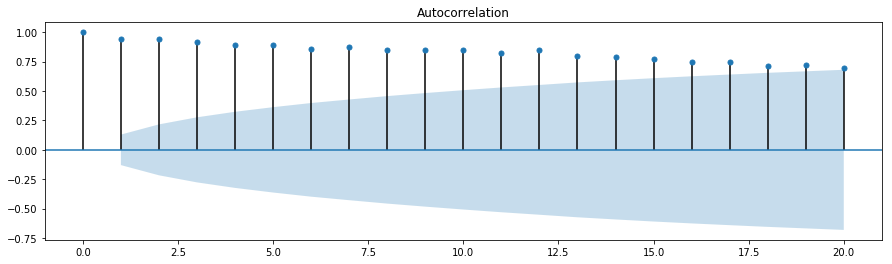

In [7]:
# plot acf
acfPlot(x=df["Milk.Prod"])

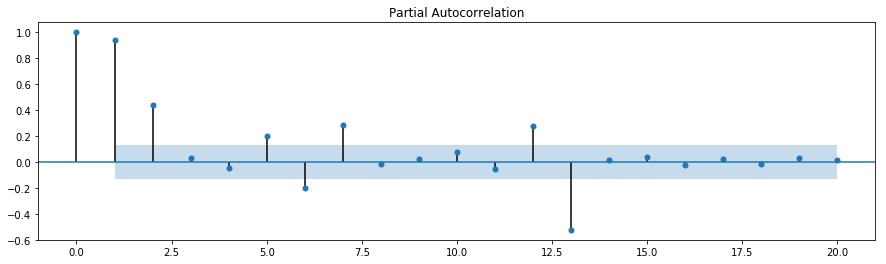

In [8]:
# plot pacf
pacfPlot(x=df['Milk.Prod'])

#### Note that the values of the ACF at the various lags decays only slowly. This indicates there is considerable serial correlation between the time series values at the various lags, mostly likely from the trend. 

#### Plotting a histogram provides information on the distribution of values of the time series. Execute the code in the cell below and examine the histogram.

In [9]:
# define a function to plot histogram of the time series
def hist_ts(series):
    fig = plt.figure(figsize=(12, 4))
    fig.clf()
    ax = fig.gca()
    series.hist(bins = 40, ax = ax)
    return 'Done'

# define a function to plot box plot of the time series
def dairy_box(df, col, by):
    fig = plt.figure(figsize=(12, 4))
    fig.clf()
    ax = fig.gca()
    df.boxplot(column = col, by = by, ax = ax)
#     ax.set_xlabel(col)
#         ax.set_ylabel('Arival Delay in minutes')
#         ax.set_title('Arival Delay by ' + col)
    return 'Done'

'Done'

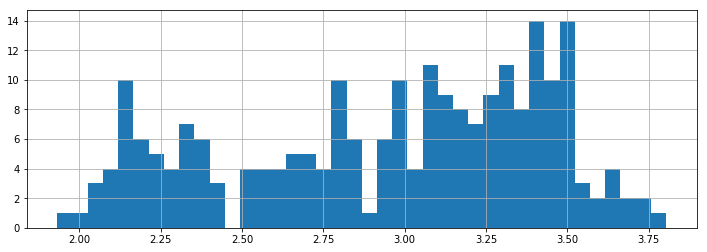

In [10]:
# plot histogram of 'Milk Production' time series
hist_ts(series=df['Milk.Prod'])

## Simple Moving Average Decomposition of the Time Series


A useful abstraction for selecting forecasting methods is to break a time series down into systematic and unsystematic components.
Systematic: Components of the time series that have consistency or recurrence and can be described and modeled.
Non-Systematic: Components of the time series that cannot be directly modeled. A given time series is thought to consist of three systematic components including level, trend, seasonality, and one non-systematic component called noise.
These components are defined as follows:
Level: The average value in the series.
Trend: The increasing or decreasing value in the series.
Seasonality: The repeating short-term cycle in the series.
Noise/Residual: The random variation in the series.

#### Time Series Components
A series is thought to be an aggregate or combination of these four components. All series have a level and noise. The trend and seasonality components are optional. It is helpful to think of the components as combining either additively or multiplicatively.
An additive model suggests that the components are added together as follows: y(t) = Level + Trend + Seasonality + Noise. An additive model is linear where changes over time are consistently made by the same amount. A linear trend is a straight line. A linear seasonality has the same frequency (width of cycles) and amplitude (height of cycles).
A multiplicative model suggests that the components are multiplied together as follows: y(t) = Level x Trend x Seasonality x Noise. A multiplicative model is nonlinear, such as quadratic or exponential. Changes increase or decrease over time. A nonlinear trend is a curved line. A non-linear seasonality has an increasing or decreasing frequency and/or amplitude over time.
 
The code in the cell below uses moving window method to compute the average of the time series over specified span - a period of 12 months here. As the moving window operator moves over the data, the average of the values in the windows is calculated. Execute the cell to load the function.

In [11]:
# function to calculate the simple moving average
def moving_avg(df,col,order):
    arr = []
    total = 0
    avg = 0
    for i in range(len(df)):
        if (i-order+1) < 0:
            df.at[i,'Moving_Average'] = 0
        else:
            if (i-order+1) == 0:
                j = 0
            else:
                j = j+1
            total = df.loc[j:i,col].sum()
            avg = total/(i-j+1)
            arr.append(avg)
            df.at[i,'Moving_Average'] = avg
            avg = 0
            total = 0
    plt.plot(df['Moving_Average'][12:])       

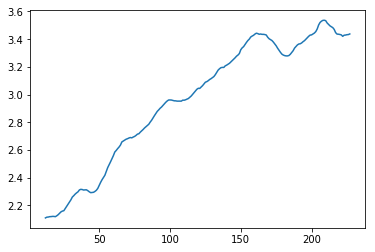

In [12]:
moving_avg(df, col = 'Milk.Prod', order = 12)

Alternatively, we can also use the 'rolling' function of pandas to calculate the simple moving average

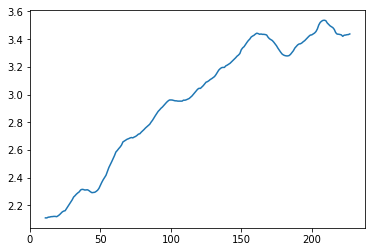

In [13]:
xx = df['Milk.Prod'].rolling(12).mean()
plt.plot(xx)

## Automatic Time Series Decomposition

There are methods to automatically decompose a time series.
The statsmodels library provides an implementation of the naive, or classical decomposition method in a function called seasonal_decompose(). It requires that we specify whether the model is additive or multiplicative.

For our problem, we will use the statsmodel library to decompose the time series into its components. The code in the cell below uses multiplicative decomposition of the time series. The moving average is computed over a twelve month moving window. 

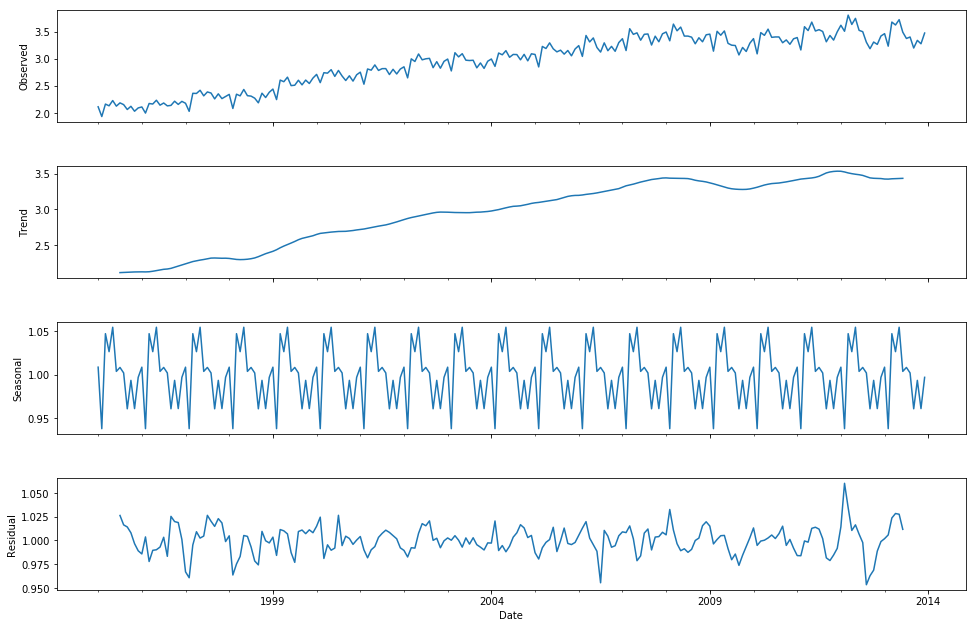

In [15]:
from statsmodels.tsa.seasonal import seasonal_decompose

def naive_decompose(df,col,model):
    result = seasonal_decompose(df[col], model=model)
    result.plot()

    fig = plt.gcf()
    ax = fig.gca()
    fig.set_size_inches(15,10)
    
    return result

df_new = df.set_index(['Date']) # seasonal_decompose requires a datetime index
na = naive_decompose(df=df_new,col='Milk.Prod',model='multiplicative')

It can be seen that the trend and seasonal components are clearly separated in the above plots. The remainder plot looks fairly random, as expected. But, is the remainder actually stationary? To test for stationarity of the remainder, plot the ACF.

In [16]:
df_new["residual_naiveDecomp"] = na.resid

df_new.dropna(axis=0,inplace=True) # drop NaN values in the residual
# df_new.isnull().sum()

df_new.head()

,Month,Year,Month.Name,Milk.Prod,Moving_Average,residual_naiveDecomp
Date,,,,,,
1995-07-01,7,1995,Jul,2.184,0.0,1.026405
1995-08-01,8,1995,Aug,2.152,0.0,1.016488
1995-09-01,9,1995,Sep,2.062,0.0,1.014267
1995-10-01,10,1995,Oct,2.121,0.0,1.008108
1995-11-01,11,1995,Nov,2.030,0.0,0.996652


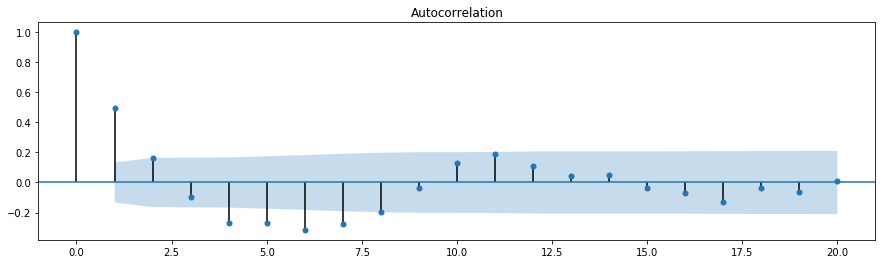

In [17]:
acfPlot(x=df_new["residual_naiveDecomp"])

The ACF shows some significant correlation among adjacent values at some lags, indicating the remainder is not, in fact, stationary. 

'Done'

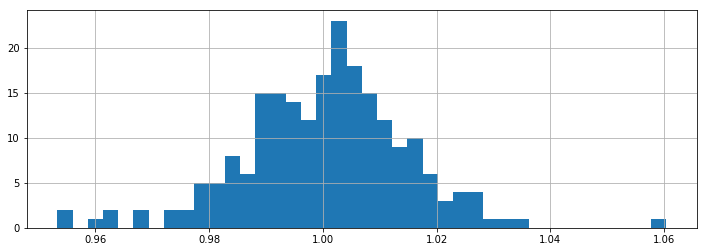

In [18]:
hist_ts(series=df_new["residual_naiveDecomp"])

'Done'

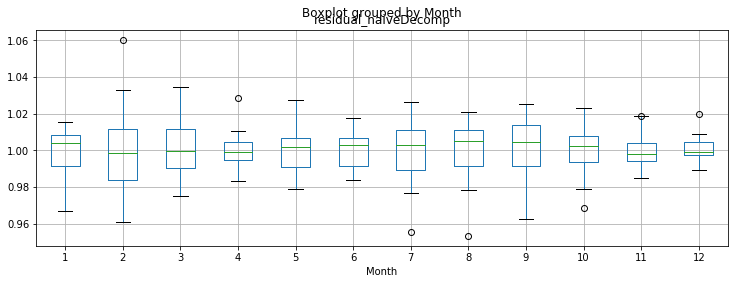

In [19]:
dairy_box(df_new,col='residual_naiveDecomp' , by='Month')

## Exploring the Multiplicative Model with lowess

Having tried a simple moving average decomposition, you will now use a lowess model to determine the trend. Lowess is a sophisticated non-linear regression. The lowess trend model is combined with a moving window seasonal component model into the R stl function. 
The code in the cell below uses stl to decompose a time series. Pandas has a package named rpy2 which enables us to use R's robust statistical decomposition with loess, but in python! A new dataframe is created with components of the time series decomposition. Plots are created of the components of the time series.

In [20]:
# import dependencies
import rpy2
from rpy2.robjects import r, pandas2ri
from rpy2.robjects.packages import importr

In [21]:
#  define a function to decompose the time series into its components using Loess
def decompose(df, col, span, frequency, Mult, s_window = 'periodic'):
#     df_stl = pd.DataFrame()
#     df_stl['date'] = df.index
    if Mult:
        series = df[col].pipe(np.log)
    else:
        series = df[col]
    s = [x for x in series.values]
    length = len(series)
    span = span*length
    s = r.ts(s, frequency=frequency,start=1)
    decomposed = [x for x in r.stl(s, s_window,t_window=span).rx2('time.series')]
    df['observed_stl'] = series.values
    df['trend_stl'] = decomposed[length:2*length]
    df['seasonal_stl'] = decomposed[0:length]
    df['residual_stl'] = decomposed[2*length:3*length]
    return df

In [25]:
df_stl = decompose(df=df_new,col='Milk.Prod',span=0.5, frequency=12, Mult=False)
df_stl.head()

,Month,Year,Month.Name,Milk.Prod,Moving_Average,residual_naiveDecomp,observed_stl,trend_stl,seasonal_stl,residual_stl
Date,,,,,,,,,,
1995-07-01,7,1995,Jul,2.184,0.0,1.026405,2.184,2.045264,0.022655,0.116081
1995-08-01,8,1995,Aug,2.152,0.0,1.016488,2.152,2.055190,0.005392,0.091417
1995-09-01,9,1995,Sep,2.062,0.0,1.014267,2.062,2.065117,-0.117860,0.114743
1995-10-01,10,1995,Oct,2.121,0.0,1.008108,2.121,2.075043,-0.022875,0.068832
1995-11-01,11,1995,Nov,2.030,0.0,0.996652,2.030,2.084970,-0.115953,0.060983


In [26]:
# define a function to create the plots of time series components
def plot_components(df,observed,trend,seasonal,residual):
    fig,(ax1,ax2,ax3,ax4) = plt.subplots(figsize=(15,12),ncols=1,nrows=4,sharex=True)
    
    df.plot(y=observed,use_index=True, ax=ax1, label='Observed')
    df.plot(y=trend,use_index=True, ax=ax2, label='Trend')
    df.plot(y=seasonal,use_index=True, ax=ax3, label='Seasonal')
    df.plot(y=residual,use_index=True, ax=ax4, label='Residual')


Text(0.5,0.98,'STL Decomposition (LOESS)')

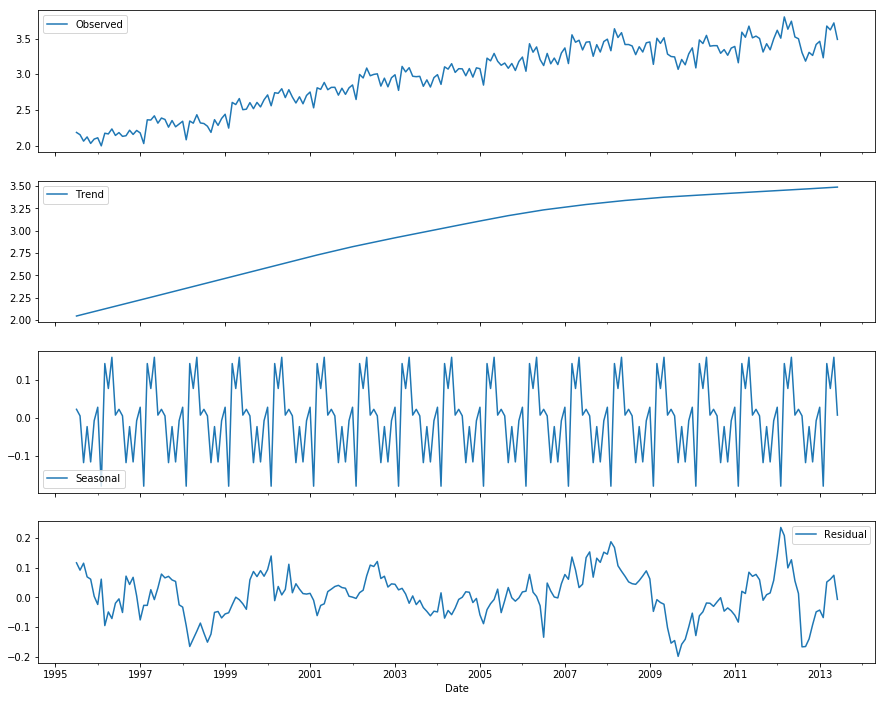

In [27]:
plot_components(df_stl,'observed_stl','trend_stl','seasonal_stl','residual_stl')
fig.suptitle('STL Decomposition (LOESS)')

The time series charts show the original time series along with the components of the decomposition. The trend is a bit smoother than was obtained with the simple moving average decomposition. 
The question remains, is the remainder from this decomposition stationary? To find out, plot the ACF.

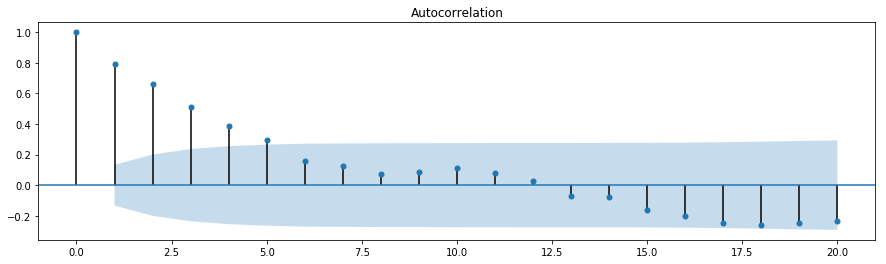

In [28]:
acfPlot(x=df_stl['residual_stl']) 

The first 4 lag values of the ACF have significant values, indicating that the remainder series is not stationary. Compared to the behavior of the ACF for the simple moving average decomposition, the behavior of the remainder is improved. 

Now, plot the histogram of the remainder by executing the code in the cell below. 

'Done'

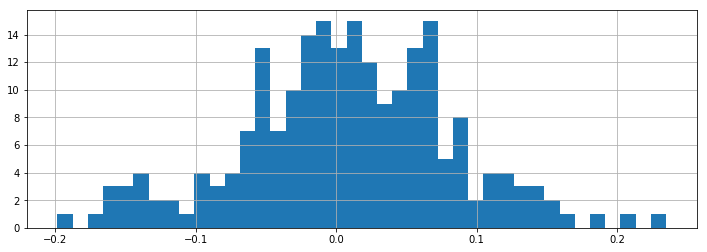

In [29]:
hist_ts(series=df_stl["residual_stl"])

The distribution of the remainder values is much closer to a Normal distribution than for the original time series we created earlier. This result, combined with the ACF plot, indicates that the stl decomposition is effective. 
We will further, investigate the remainder (non-seasonal residual) component by making a box plot by month of the year. The code in the cell below plots a box plot by month of the remainder component. 

'Done'

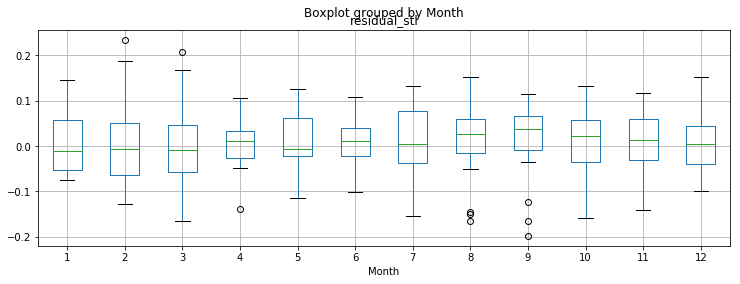

In [30]:
dairy_box(df_stl,col='residual_stl' , by='Month')

The remainder component shows only limited vairation from month to month. The differences are within the interquartile range, indicating that the seasonal model is a reasonably good fit. 

## Moving Average Models
Now that we have explored the decomposition of the time series, we will now construct and test Autoregressive Moving Average (ARMA) models for the remainder of the time series. We will create and test these models in three steps, creating a moving average (MA) model, creating an autoregressive (AR) model and creating an autoregressive moving average (ARMA) model. 
The function in the cell below computes an Autoregressive Integrative Moving Average (ARIMA) model. The summary statistics for the model are printed and the model object returned. By assigning values to the order of each operator, different time series models can be specified, as order of MA model, order of Integrative model, and order of AR model. 
The ACF of the remainder from the stl decomposition of the milk production time series had 5 significant lag values. As an inital model, we will now create an MA model of order 5. Execute the code in the cell below to compute the MA(5) model and examine the model summary. 

C:\Users\Akanksha\Anaconda3\envs\PythonData\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
C:\Users\Akanksha\Anaconda3\envs\PythonData\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):


                              ARMA Model Results                              
Dep. Variable:           residual_stl   No. Observations:                  216
Model:                     ARMA(0, 5)   Log Likelihood                 368.649
Method:                       css-mle   S.D. of innovations              0.044
Date:                Wed, 30 Jan 2019   AIC                           -723.297
Time:                        08:32:08   BIC                           -699.670
Sample:                    07-01-1995   HQIC                          -713.752
                         - 06-01-2013                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.0087      0.010      0.830      0.408      -0.012       0.029
ma.L1.residual_stl     0.7029      0.069     10.249      0.000       0.568       0.837
ma.L2.residual_stl  

C:\Users\Akanksha\Anaconda3\envs\PythonData\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


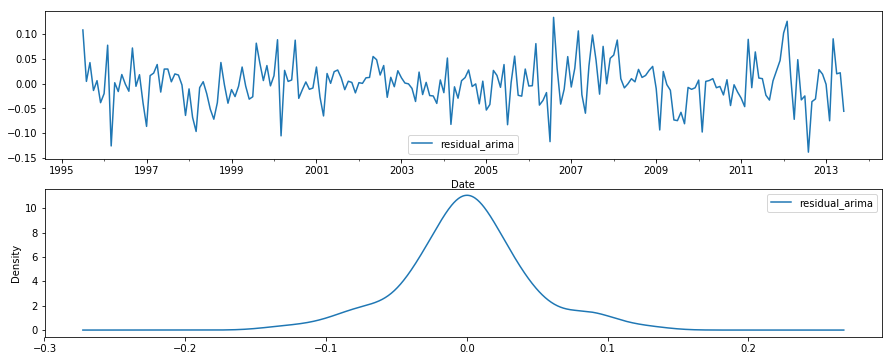

In [42]:
from statsmodels.tsa.arima_model import ARIMA

def arima_model(df,col,order):
    # fit model
    model = ARIMA(df[col], order=order)
    model_fit = model.fit(disp=0)
    print(model_fit.summary())
    
    # plot the residual
    residual_arima_df = pd.DataFrame(model_fit.resid,columns=['residual_arima'])
    fig,(ax1,ax2) = plt.subplots(figsize=(15,6),ncols=1,nrows=2,sharex=False)
    residual_arima_df.plot(kind='line',ax=ax1)
    residual_arima_df.plot(kind='kde',ax=ax2) # kde stands for Kernel Density Estimation plot
    return residual_arima_df

res_ma = arima_model(df=df_stl,col='residual_stl',order=(0,0,5))
    

The small standard error compared to the magnitude of the coefficients indicates that the order of the model is reasonable. 
To test how well this model fits the data, and results in a stationary result, we will plot the ACF of the residuals of the MA(5) model. Run the code in the cell below to plot the ACF of the model result. 

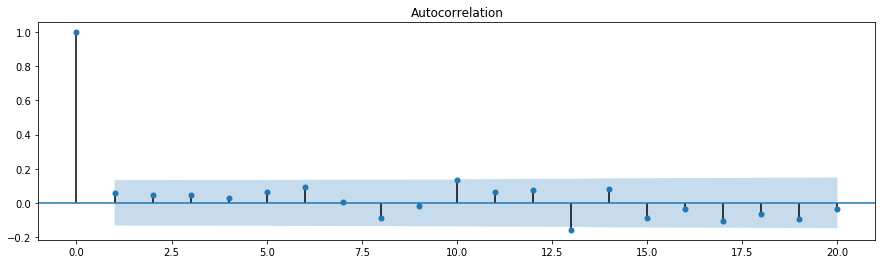

In [41]:
acfPlot(x=res_ma['residual_arima']) 

Note that only the 0 lag of the ACF is significant and that there are no significant lags for the PACS. These observations indicate that the MA(5) model is a good fit. 

## Autoregressive Models
The MA(5) model has been shown to be effective. Next, we will test an autoregressive model. The PACF of the reminder indicates that an AR model might not be the best choice. None the less, a low order AR model might fit these data. To compute an AR(2) model exectue the code in the cell below. 

C:\Users\Akanksha\Anaconda3\envs\PythonData\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
C:\Users\Akanksha\Anaconda3\envs\PythonData\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):
C:\Users\Akanksha\Anaconda3\envs\PythonData\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


                              ARMA Model Results                              
Dep. Variable:           residual_stl   No. Observations:                  216
Model:                     ARMA(2, 0)   Log Likelihood                 363.082
Method:                       css-mle   S.D. of innovations              0.045
Date:                Wed, 30 Jan 2019   AIC                           -718.165
Time:                        08:35:44   BIC                           -704.664
Sample:                    07-01-1995   HQIC                          -712.710
                         - 06-01-2013                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.0100      0.016      0.617      0.538      -0.022       0.042
ar.L1.residual_stl     0.7284      0.068     10.711      0.000       0.595       0.862
ar.L2.residual_stl  

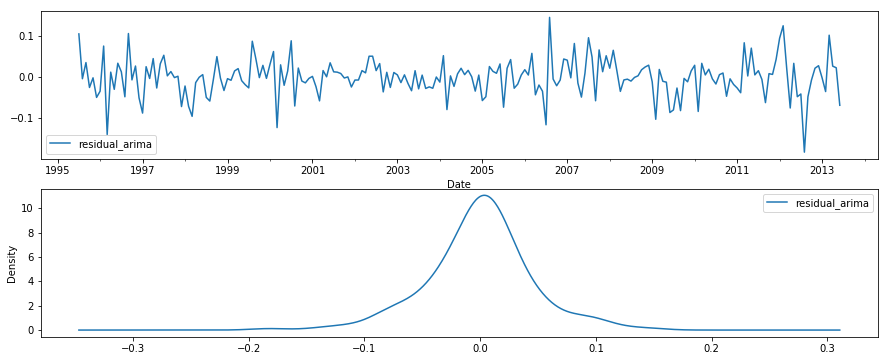

In [43]:
res_ar2= arima_model(df=df_stl,col='residual_stl',order=(2,0,0))

Examine the values of the coefficients and their standard errors. Note that the standard error of the second coefficient is almost of the same magnitude as the coefficient. Clearly, the AR(2) model is over parameterized. 
Next, we will try an AR(1) model, by executing the code in the cell below.

C:\Users\Akanksha\Anaconda3\envs\PythonData\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
C:\Users\Akanksha\Anaconda3\envs\PythonData\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):
C:\Users\Akanksha\Anaconda3\envs\PythonData\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


                              ARMA Model Results                              
Dep. Variable:           residual_stl   No. Observations:                  216
Model:                     ARMA(1, 0)   Log Likelihood                 362.266
Method:                       css-mle   S.D. of innovations              0.045
Date:                Wed, 30 Jan 2019   AIC                           -718.532
Time:                        08:39:20   BIC                           -708.406
Sample:                    07-01-1995   HQIC                          -714.441
                         - 06-01-2013                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.0095      0.015      0.638      0.524      -0.020       0.039
ar.L1.residual_stl     0.7982      0.041     19.572      0.000       0.718       0.878
                    

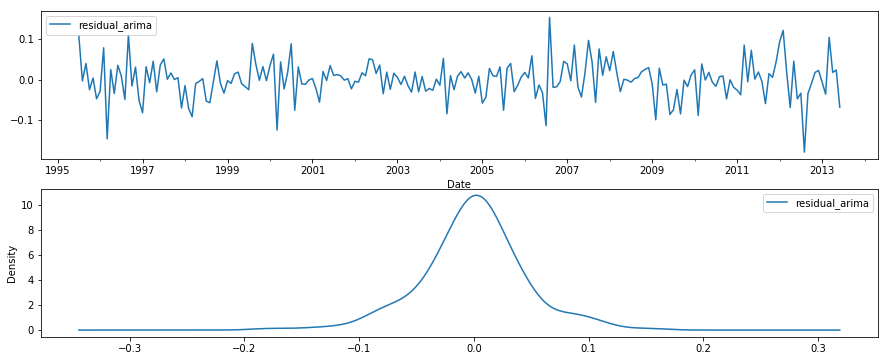

In [44]:
res_ar1 = arima_model(df=df_stl,col='residual_stl',order=(1,0,0))

The standard error of the AR(1) model is an order of magnitude less than the value of the coefficient, which is promising.
Next, exectue the code in the cell below to plot the ACF and PACF of the AR(1) model

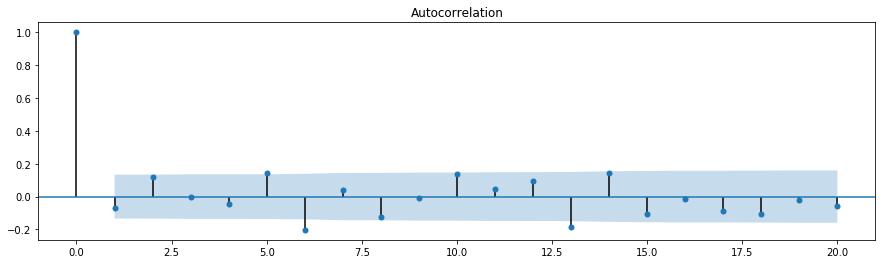

In [46]:
acfPlot(x=res_ar1['residual_arima']) 

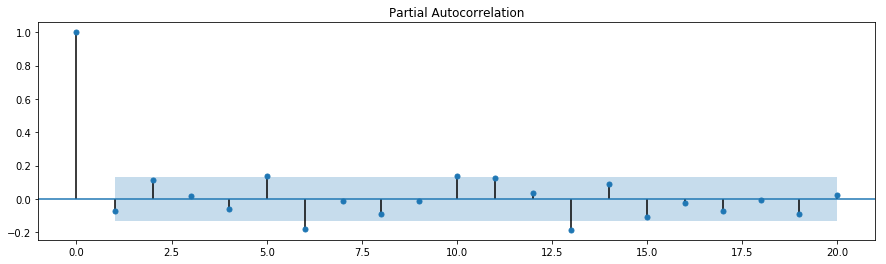

In [47]:
pacfPlot(x=res_ar1['residual_arima'])

Note that only the 0 lag of the ACF is significant and that there are no significant lags for the PACF. These observations indicate that the AR(1) model is a good fit. Compare these results to those of the MA(3) model, noting that they are nearly identical. Evidently, either the MA(5) or AR(1) model is a good choice for these data. 

## Autoregressive Moving Average Models
We have found that both MA(5) and AR(1) models are good fits to the remainder series. We will now investigate the use of autoregressive moving average (ARMA) models on the remainder series. 
As a starting point we will try an ARMA(1,5) model by executing the code in the cell below. 

C:\Users\Akanksha\Anaconda3\envs\PythonData\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
C:\Users\Akanksha\Anaconda3\envs\PythonData\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):


                              ARMA Model Results                              
Dep. Variable:           residual_stl   No. Observations:                  216
Model:                     ARMA(1, 5)   Log Likelihood                 371.841
Method:                       css-mle   S.D. of innovations              0.043
Date:                Wed, 30 Jan 2019   AIC                           -727.682
Time:                        08:46:03   BIC                           -700.680
Sample:                    07-01-1995   HQIC                          -716.773
                         - 06-01-2013                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.0091      0.013      0.695      0.488      -0.016       0.035
ar.L1.residual_stl     0.3888      0.130      2.994      0.003       0.134       0.643
ma.L1.residual_stl  

C:\Users\Akanksha\Anaconda3\envs\PythonData\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


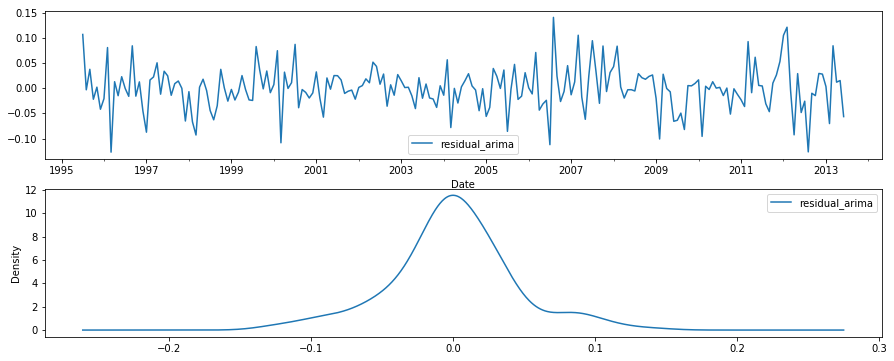

In [48]:
res_arma = arima_model(df=df_stl,col='residual_stl',order=(1,0,5))

In each case, the standard error is of lesser magnitude as the value of the coefficient, indicating this model is a reasonable fit to the data.

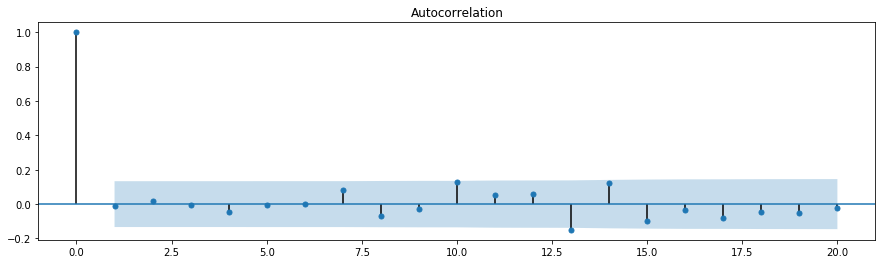

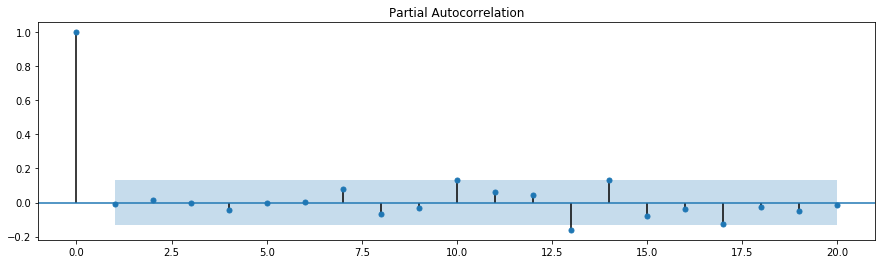

In [49]:
acfPlot(x=res_arma['residual_arima']) 
pacfPlot(x=res_arma['residual_arima']) 

## Autoregressive Integrative Moving Average Model
We will now model the remainder series with an autoregressive integrative moving average (ARIMA) model.
Execute the code in the cell below to compute an ARIMA(1,1,1) model.

C:\Users\Akanksha\Anaconda3\envs\PythonData\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
C:\Users\Akanksha\Anaconda3\envs\PythonData\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):
C:\Users\Akanksha\Anaconda3\envs\PythonData\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


                             ARIMA Model Results                              
Dep. Variable:         D.residual_stl   No. Observations:                  215
Model:                 ARIMA(1, 1, 1)   Log Likelihood                 353.202
Method:                       css-mle   S.D. of innovations              0.047
Date:                Wed, 30 Jan 2019   AIC                           -698.403
Time:                        09:01:10   BIC                           -684.921
Sample:                    08-01-1995   HQIC                          -692.956
                         - 06-01-2013                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -0.0005      0.003     -0.182      0.856      -0.006       0.005
ar.L1.D.residual_stl    -0.2805      0.356     -0.787      0.432      -0.979       0.418
ma.L1.D.resi

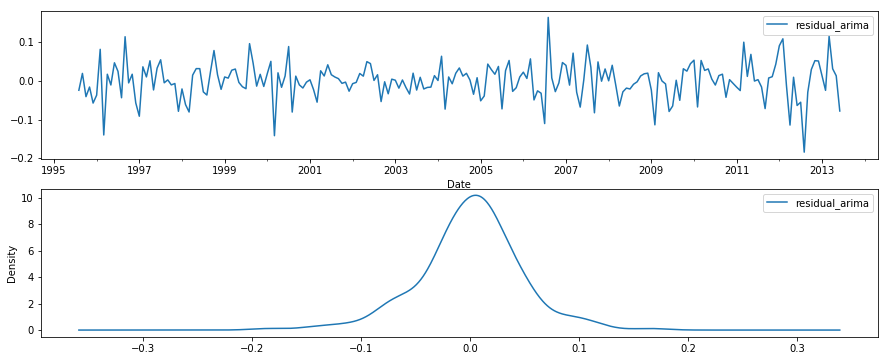

In [63]:
res_arima = arima_model(df=df_stl,col='residual_stl',order=(1,1,1))

The coefficient of the ar1 is negative and the standard error of the ma1 coefficient is more than the coefficient value.This model does not seem to be a reasonable fit. Next, plot the ACF and PACF of the model by executing the code in the cell below. 

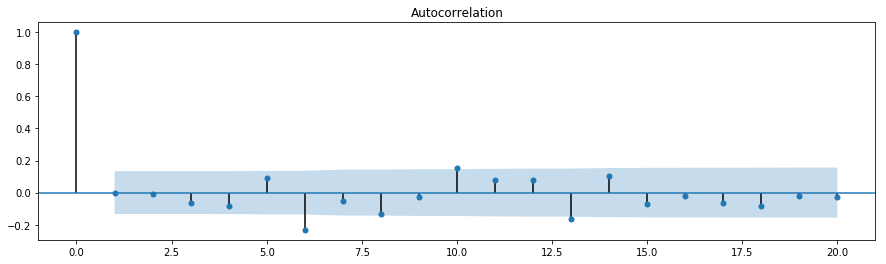

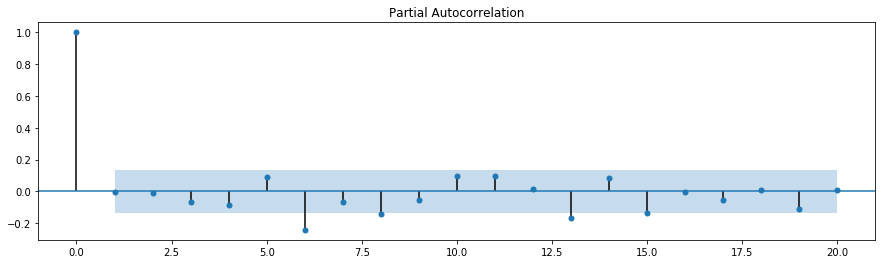

In [64]:
acfPlot(x=res_arima['residual_arima']) 
pacfPlot(x=res_arima['residual_arima'])

Note that only the 0 lag of the ACF is significant and that there are no significant lags for the PACF. These observations indicate that the ARIMA(1,1,1) model is a good fit. Compare these results to those of the MA(3) and AR(1) models, noting that they are nearly identical. The ARIMA(1,1,1) model is a good choice for these data as well. 

## Summary
In this project,we have learned to work with and analyze time series data. Specifically, we have done the following:

- Examined the properties of time series objects.
- Plotted time series data.
- Decomposed time series data into its trend, seasonal, and remainder components.
- Modeled the remainder components as AR, MA, ARMA and ARIMA models. 
- Created and evaluated difference series methods.